In [37]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
# Für Pynq
from pynq import Overlay
from pynq import allocate
# ol = Overlay("Matlab_Filter_v2_18_4_v2.bit")  # max output2^18, dma 2^26 (max),Fc 1 kHz, FilterOrder = 4 , ellip, v.2.3
ol = Overlay("Matlab_Filter_v2_18_4_v3.bit")  # max output2^18, dma 2^26 (max),Fc 1 kHz, FilterOrder = 4,butter, v.2.4
# Check IP names
ol.ip_dict.keys()

dict_keys(['axi_dma_0', 'BiquadFilter_HP_Butt_0', 'processing_system7_0'])

In [38]:
# Zuweisung für dma
dma = ol.axi_dma_0
dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel
# check status
print("Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

Error:  False Idle:  False Running:  True
Error:  False Idle:  False Running:  True


In [39]:
# Funktionen
def FormatChange(x):
    x = x * (2**15)                            # Skalieren auf Q16.16 Bereich (optional leicht unter max)
    x = x.astype(np.int32)                     # Als 32-Bit Integer interpretieren
    input_data = x.view(np.uint32)             # Für DMA als unsigned darstellen
    return input_data

# Normierung Wichtig für .wav-Files!
def Normierung(x):
    m = np.max(np.abs(x))                      # Maxwert für Normalisierung
    x_n = x / m 
    return x_n


def Transmission(input_data,ip_buffer):
    # Festlegen der Größen
    buffer_size = int(ip_buffer)
    # print("Buffer Size: ", buffer_size)
    input_data = FormatChange(Normierung(input_data))
    data_size = int(len(input_data))
    print('Data Size: ', data_size)
    
    # Padding
    pad = np.zeros(ip_buffer)
    pad_frame = FormatChange(pad)
    # print('Frame Length: ', len(pad_frame),' / ', 'Frame Type: ', type(pad_frame))
    
    # Leere Buffer
    input_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
    output_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
    
    # Padding Inputbuffer
    input_buffer[:] = pad_frame
    
    # Laden der Daten in Inputbuffer
    input_buffer[: data_size] = input_data
    # print('Input Buffer: ', input_buffer[: data_size])
    
    # Senden un Empfangen der Daten
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    # check status
    #print("Recv Status: ","Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
    #print("Send Status: ","Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)
    
    # print('Output Buffer: ', output_buffer[: data_size])
    
    # Check for Error
    if dma_recv.error == False and dma_send.error == False:
        print('>>>> Transmission successful <<<<')
    elif dma_recv.error == True or dma_send.error == True:
        print('!!!>> Error in Transmission <<!!!')
    
    # Umrechnen der Empfangenen Daten
    output_data = np.array(output_buffer[: data_size]).view(np.int32)  # zurück zu signed int32
    # output_data = np.array(output_buffer).view(np.int32)  Test des Kompletten Frame
    y = output_data / (2**15)
    
    
    # Buffer leeren
    del input_buffer, output_buffer
    print('Buffer Clear')
    print('>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<')
    
    return y
    
def Split2Packets(data,packet_size):
    packets = []
    for i in range(0, len(data), packet_size):
        packet = data[i:i+packet_size]
        packets.append(packet)
    return packets  



In [40]:
file_name  = 'tf2_test_sound.wav'
Fs, data = wavfile.read(file_name)

# Print Samaplerate
print(Fs, 'Hz')

# Check if Mono or Sterio
if len(data.shape) == 2:
    print('Sterio')
elif len(data.shape) == 1:
    print('Mono')

# Check datatype
print(type(data))

scale = 10*Fs

# Read Data
data_l_temp = data[:,0]
data_r_temp = data[:,1]

data_l = data_l_temp
data_r = data_l_temp

N = data_l.size
Ts = 1/Fs
t_temp = np.arange(N)*Ts
t = t_temp


44100 Hz
Sterio
<class 'numpy.ndarray'>


In [ ]:
# Scaled File
scale = 10*Fs
data_l = data_l_temp[: scale]
data_r = data_l_temp[: scale]
t = t_temp[: scale]

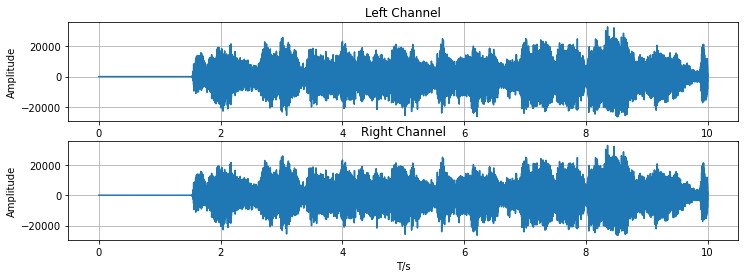

In [20]:
# Plot Data
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.title('Left Channel')
plt.plot(t,data_l)
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(2,1,2)
plt.title('Right Channel')
plt.plot(t,data_r)
plt.ylabel('Amplitude')
plt.grid()
plt.xlabel('T/s')
plt.show()

In [41]:
ip_buffer = 2**18
# Filtern Limker Kanal
Data_In_L = data_l
Data_Out_L = []

# Zerteilung und Übertragung in Packeten
Packets = Split2Packets(Data_In_L, ip_buffer)

for packet in Packets:
    result = Transmission(packet, ip_buffer)
    Data_Out_L.extend(result)

Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  184320
>>>> Transmission suc

In [42]:
ip_buffer = 2**18
# Filtern Rechter Kanal
Data_In_R = data_r
Data_Out_R = []

# Zerteilung und Übertragung in Packeten
Packets = Split2Packets(Data_In_R, ip_buffer)

for packet in Packets:
    result = Transmission(packet, ip_buffer)
    Data_Out_R.extend(result)

Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  262144
>>>> Transmission successful <<<<
Buffer Clear
>-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-<
Data Size:  184320
>>>> Transmission suc

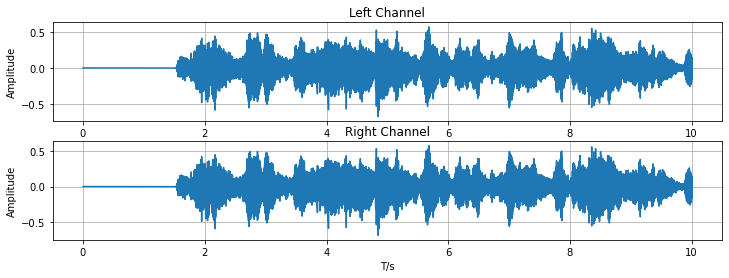

In [23]:
# Plot Data
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.title('Left Channel')
plt.plot(t,Data_Out_L)
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(2,1,2)
plt.title('Right Channel')
plt.plot(t,Data_Out_R)
plt.ylabel('Amplitude')
plt.grid()
plt.xlabel('T/s')
plt.show()

In [9]:
print(type(Data_Out_L),type(Data_Out_R))

<class 'list'> <class 'list'>


In [43]:
# Umrechnen in np.array
Data_Out_L = np.array(Data_Out_L)
Data_Out_R = np.array(Data_Out_R)
print(Data_Out_L.dtype, Data_Out_R.dtype)

float64 float64


In [44]:
# Umrechnen für erstellung .wav-File
data_l_int16 = (Data_Out_L * 32767).astype(np.int16)
data_r_int16 = (Data_Out_R * 32767).astype(np.int16)

from scipy.io.wavfile import write

#file_name = 'output.wav'

# file_name = 'output_Ellip.wav'
file_name = 'output_butter.wav'

stereo_data = np.stack((data_l_int16, data_r_int16), axis=-1)
write(file_name, Fs, stereo_data)

In [45]:
from IPython.display import Audio as IPAudio
IPAudio(file_name)